In [1]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_roc_curve


from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier


In [2]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('../data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('../data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('../data/dict_map.pickle','rb')
dict_map = pickle.load(f)

# Create the Data Set

In [44]:
DAYS_WEIGHT = 90

time_1 = datetime.now()



# If we want matches only between only ranked teams
df_tmp = df_map[ (df_map['date']>datetime(2019,1,1)) &
    ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) ) ]


df_two_year = df_map[ (df_map['date']>datetime(2018,1,1)) ]


dict_train = {}

print( len( df_tmp['map_id']) )



# Function to append values of all the players
def append_val(team_01,stat_vec,stat_name,dict_inout):

    n = len(stat_vec)
    order = np.argsort( stat_vec )[::-1][:n]

    count_p = -1
    for ind in order:
        count_p = count_p + 1
        dict_inout['t_'+team_01+'_p_'+str(count_p)+'_'+stat_name] = stat_vec[ind]
    
    return dict_inout
    

#2000 -> ~4min
for map_id in df_tmp['map_id'][:]:

    map_date = df_tmp.loc[map_id]['date']

    dict_train[map_id] = {}    

    # Here we are taking the rankings to be non-zero
    rank_1 = df_tmp.loc[map_id]['team_rank_1']
    rank_2 = df_tmp.loc[map_id]['team_rank_2']

    team_id_1 = df_tmp.loc[map_id]['team_id_1']
    team_id_2 = df_tmp.loc[map_id]['team_id_2']

    winner = df_tmp.loc[map_id]['winner']

    if rank_1 < rank_2:
        # Team_1 is the favorite

        fav = 0
        
        if winner == 1:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

        dict_train[map_id]['rank_fav'] = rank_1
        dict_train[map_id]['rank_dog'] = rank_2


    else:
        # Team_2 is the favorite

        fav = 1  

        if winner == 2:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

        dict_train[map_id]['rank_fav'] = rank_2
        dict_train[map_id]['rank_dog'] = rank_1

    count_team = -1
    for team_id in dict_map[map_id]:

        count_team = count_team + 1

        rating_vec    = []
        prize_rtg_vec = []
        hs_vec        = []
        kills_per_rd_vec  = []
        deaths_per_rd_vec = []
        adr_vec = []
        kast_vec = []
        assists_per_rd_vec = []
        flash_per_rd_vec   = []
        first_kills_dif_vec = []
        team_rank_vec = []
        score_dif_vec = []
        win_rate_vec = [] 

        for player_id in dict_map[map_id][team_id]['players_id']:            

            
            # Get the data for this player
            df_aux   = dict_player[player_id]
            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            # Note the prize rating we take a whole year back
            prize = df_aux[ (date_vec>1) & (date_vec<365) ]['prize'].sum()
            if prize > 0.0:
                prize_rtg_vec.append( np.log( prize )/12.0 )
            else:
                prize_rtg_vec.append( 0.0 )

            df_aux   = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            # Append the average values of this player 
            rating_vec.append         ( df_aux['rating'].mean() )
            hs_vec.append             ( (df_aux['hs_kills']/(df_aux['team_score']+df_aux['op_score'])).mean() )        
            kills_per_rd_vec.append   ( df_aux['kills_per_round'].mean() )
            deaths_per_rd_vec.append  ( df_aux['deaths_per_round'].mean() )
            adr_vec.append            ( df_aux['ADR'].mean() )
            kast_vec.append           ( df_aux['KAST'].mean() )
            assists_per_rd_vec.append ( (df_aux['assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            flash_per_rd_vec.append   ( (df_aux['flash_assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            first_kills_dif_vec.append( (df_aux['first_kills_diff']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            team_rank_vec.append      ( df_aux['team_rank'].mean() )
            score_dif_vec.append      ( (df_aux['team_score']-df_aux['op_score']).mean() )
            win_rate_vec.append       ( df_aux['win'].mean() )


        if count_team == fav:
            t = '0'
            
        else:
            t = '1'

        dict_train[map_id] = append_val(t,prize_rtg_vec,'prize_rating',dict_train[map_id])

        dict_train[map_id] = append_val(t,rating_vec,'rating',dict_train[map_id])
        dict_train[map_id] = append_val(t,hs_vec,'hs_perc',dict_train[map_id])
        dict_train[map_id] = append_val(t,kills_per_rd_vec,'kills_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,deaths_per_rd_vec,'deaths_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,adr_vec,'adr',dict_train[map_id])
        dict_train[map_id] = append_val(t,kast_vec,'kast',dict_train[map_id])
        dict_train[map_id] = append_val(t,assists_per_rd_vec,'assists_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,flash_per_rd_vec,'flash_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,first_kills_dif_vec,'first_kills_dif',dict_train[map_id])
        dict_train[map_id] = append_val(t,team_rank_vec,'team_rank',dict_train[map_id])
        dict_train[map_id] = append_val(t,score_dif_vec,'score_dif',dict_train[map_id])
        dict_train[map_id] = append_val(t,win_rate_vec,'win_rate',dict_train[map_id])


        # n = len(rating_vec)
        # order = np.argsort( rating_vec )[::-1][:n]

        # if count_team == fav:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_rating'] = rating_vec[ind]
                
        # else:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_rating'] = rating_vec[ind]
                

        # if count_team == fav:

        #     dict_train[map_id]['t0_prize'] = np.average( prize )
        #     dict_train[map_id]['t_0_avg_rating'] = np.average( weighted_rating )
            
        # else:

        #     dict_train[map_id]['t1_prize'] = np.average( prize )
        #     dict_train[map_id]['t_1_avg_rating'] = np.average( weighted_rating )
            
    

time_2 = datetime.now()

print( time_2-time_1 )
#date_vec

10466
0:11:35.248462


In [49]:
df_train = pd.DataFrame.from_dict(dict_train,orient='index')

#df_train.head(n=100)['t_0_p_2_score_dif']
df_train.head()

,fav_win,rank_fav,rank_dog,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,t_0_p_3_prize_rating,t_0_p_4_prize_rating,t_0_p_0_rating,t_0_p_1_rating,...,t_1_p_0_score_dif,t_1_p_1_score_dif,t_1_p_2_score_dif,t_1_p_3_score_dif,t_1_p_4_score_dif,t_1_p_0_win_rate,t_1_p_1_win_rate,t_1_p_2_win_rate,t_1_p_3_win_rate,t_1_p_4_win_rate
79922,0,77,86,0.660299,0.660299,0.575646,0.000000,0.000000,1.14,1.065000,...,0.636364,0.529412,0.529412,0.081081,0.081081,0.545455,0.529412,0.529412,0.486486,0.486486
79923,0,77,86,0.660299,0.660299,0.575646,0.000000,0.000000,1.14,1.065000,...,0.636364,0.529412,0.529412,0.081081,0.081081,0.545455,0.529412,0.529412,0.486486,0.486486
79943,1,72,152,0.740634,0.731630,0.724612,0.724612,0.724612,1.25,1.110189,...,2.769231,2.769231,2.117647,0.774194,0.466667,0.615385,0.615385,0.555556,0.548387,0.529412
79945,0,72,152,0.740634,0.731630,0.724612,0.724612,0.724612,1.25,1.110189,...,2.769231,2.769231,2.117647,0.774194,0.466667,0.615385,0.615385,0.555556,0.548387,0.529412
79947,0,72,152,0.740634,0.731630,0.724612,0.724612,0.724612,1.25,1.110189,...,2.769231,2.769231,2.117647,0.774194,0.466667,0.615385,0.615385,0.555556,0.548387,0.529412


In [80]:
# Here we do some feature engineering
df_all_feat = pd.DataFrame.from_dict(dict_train,orient='index')

df_all_feat = df_all_feat.fillna(0)

df_train = pd.DataFrame()
df_train['fav_win'] = df_all_feat['fav_win']

feat_names = ['prize_rating','rating','hs_perc','kills_per_rd','deaths_per_rd','adr',
                'kast','assists_per_rd','flash_per_rd','first_kills_dif','team_rank','score_dif','win_rate']


for feat in feat_names:
    avg_0 = 0.0
    avg_1 = 0.0
    for ind in range(0,5):
        # df_train[feat+'_p_'+str(ind)+'_dif'] = df_all_feat['t_0_p_'+str(ind)+'_'+feat] - df_all_feat['t_1_p_'+str(ind)+'_'+feat]
       avg_0 = avg_0 + df_all_feat['t_0_p_'+str(ind)+'_'+feat]
       avg_1 = avg_1 + df_all_feat['t_1_p_'+str(ind)+'_'+feat]

    df_train[feat+'_dif'] = ( avg_0 - avg_1 ) / 5.0

# Does it help if we normalize everything?
for column in df_train:
    if column != 'fav_win':
        df_train[column] = (df_train[column]-df_train[column].mean())/df_train[column].std()



#print(df_train.keys())

print(df_train['fav_win'].mean())

df_train.tail(n=80)

0.6120772023695776


,fav_win,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,assists_per_rd_dif,flash_per_rd_dif,first_kills_dif_dif,team_rank_dif,score_dif_dif,win_rate_dif
97490,0,0.255088,-0.664518,-0.906710,-0.775825,0.429944,-0.712622,-0.493330,0.324592,0.316981,-0.885063,-1.538828,-0.955792,-0.815703
97491,1,-2.200739,-2.563849,-1.313758,-2.313761,-1.314564,-2.490890,-3.366436,-2.673759,-1.390750,-0.304424,0.287940,-0.909053,-1.706335
97492,0,-0.895468,-0.253879,-0.436858,-0.178158,0.093241,-0.306088,-0.217878,-1.847514,-2.727817,-0.237604,0.204932,-0.860557,-0.886862
97493,1,0.255088,-0.664518,-0.906710,-0.775825,0.429944,-0.712622,-0.493330,0.324592,0.316981,-0.885063,-1.538828,-0.955792,-0.815703
97494,0,-0.895468,-0.253879,-0.436858,-0.178158,0.093241,-0.306088,-0.217878,-1.847514,-2.727817,-0.237604,0.204932,-0.860557,-0.886862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97582,1,-0.388482,-0.128942,-0.149762,-0.192290,0.011852,-0.224688,0.034684,-0.167636,-0.557153,-0.855270,0.239241,-0.533365,-0.325332
97586,1,-0.388482,-0.128942,-0.149762,-0.192290,0.011852,-0.224688,0.034684,-0.167636,-0.557153,-0.855270,0.239241,-0.533365,-0.325332
97591,1,0.052867,-0.595770,-0.527850,-0.404066,0.058039,-0.519078,-0.526353,-1.602287,-2.135924,0.199758,0.082688,-0.826782,-1.067831
97593,0,0.052867,-0.595770,-0.527850,-0.404066,0.058039,-0.519078,-0.526353,-1.602287,-2.135924,0.199758,0.082688,-0.826782,-1.067831


# Here we process the results we got

# Now the Logistic regression model

# All models at once

--------------------------------------------------------------
Logistic

>               precision    recall  f1-score   support

Underdog wins       0.54      0.19      0.28      1027
Favorite wins       0.63      0.90      0.74      1590

     accuracy                           0.62      2617
    macro avg       0.59      0.54      0.51      2617
 weighted avg       0.60      0.62      0.56      2617

[[ 192  835]
 [ 161 1429]]
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.53      0.21      0.30      1027
Favorite wins       0.63      0.88      0.74      1590

     accuracy                           0.62      2617
    macro avg       0.58      0.55      0.52      2617
 weighted avg       0.59      0.62      0.57      2617

[[ 217  810]
 [ 192 1398]]
--------------------------------------------------------------
Random Forest

>               precision    recall  f1-score   support

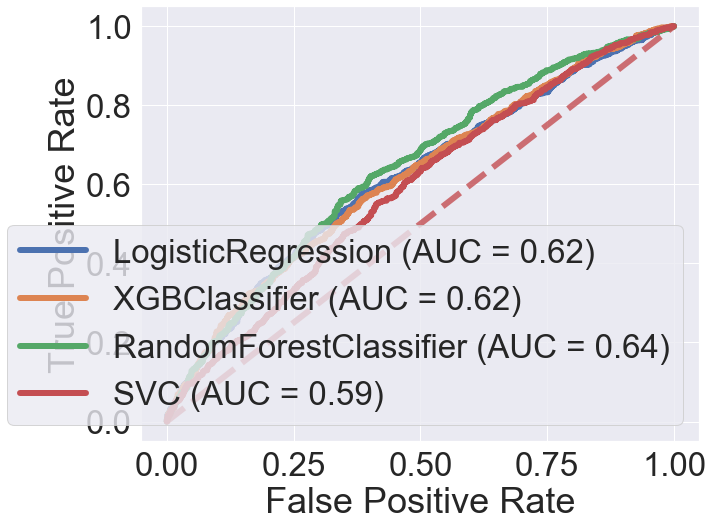

In [151]:
df_tmp = df_train.copy()

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('--------------------------------------------------------------')
print('Logistic')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

# accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
# print(accuracy)

# y_scores = logmodel.predict_proba(X_test)[:,1]

# roc_auc_score(y_test, y_scores)


# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# c_mat = confusion_matrix(y_test, predictions)
# print( c_mat )

print('--------------------------------------------------------------')
print('XGBoost')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )




# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

clf = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=1,bootstrap=True)
clf.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf.predict(X_test)

print('--------------------------------------------------------------')
print('Random Forest')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )


# SVM
clf_svm = svm.SVC(probability=True)
clf_svm.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf_svm.predict(X_test)

print('--------------------------------------------------------------')
print('Support Vector Machines')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )



# AUC ROC
sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(10,8));
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf_svm, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()

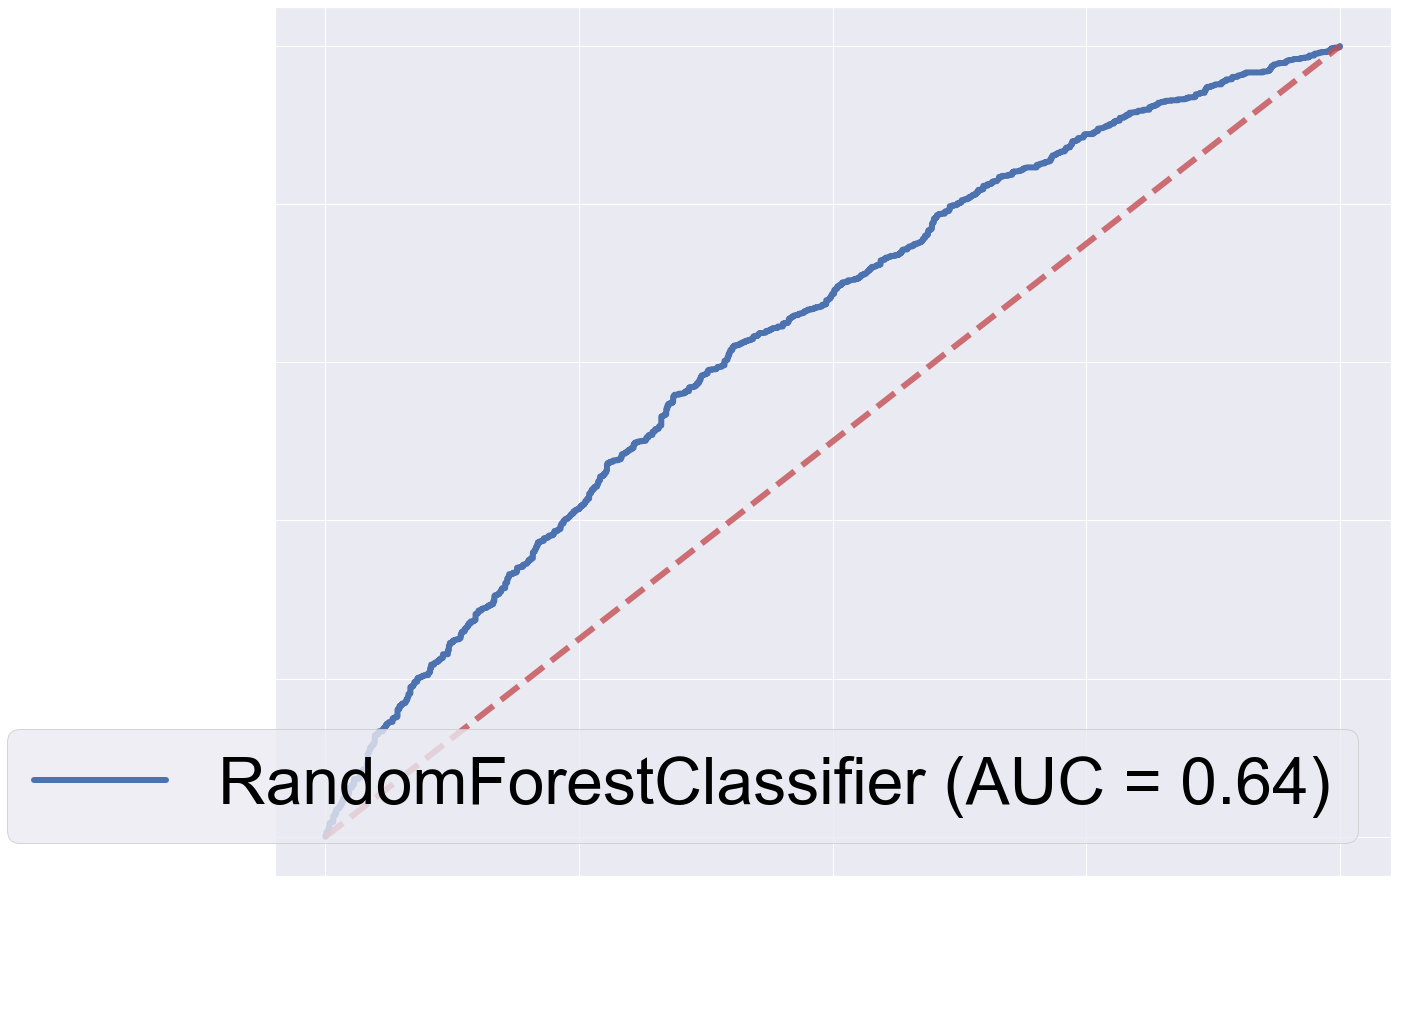

In [155]:
sns.set_style("whitegrid")
sns.set(font_scale=6)


mpl.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

plt.figure(figsize=(20,16));



ax = plt.axes()

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.savefig('roc.svg', transparent=True, bbox_inches="tight")

plt.show()

In [132]:
df_a.keys()[:]

Index(['prize_rating_dif', 'rating_dif', 'hs_perc_dif', 'kills_per_rd_dif',
       'deaths_per_rd_dif', 'adr_dif', 'kast_dif', 'assists_per_rd_dif',
       'flash_per_rd_dif', 'first_kills_dif_dif', 'team_rank_dif',
       'score_dif_dif', 'win_rate_dif'],
      dtype='object')

Feature ranking:
1. feature 0, $\Delta$ Prize Rating (0.179924)
2. feature 6, $\Delta$ KAST (0.080366)
3. feature 10, $\Delta$ Rank (0.076097)
4. feature 5, $\Delta$ ADR (0.075769)
5. feature 12, $\Delta$ Win % (0.072508)
6. feature 1, $\Delta$ Rating (0.068738)
7. feature 3, $\Delta$ Kills (0.066354)
8. feature 7, $\Delta$ Assists (0.065640)
9. feature 9, $\Delta$ First Kills (0.064018)
10. feature 2, $\Delta$ HS % (0.063680)
11. feature 11, $\Delta$ Score (0.062426)
12. feature 4, $\Delta$ Deaths (0.062260)
13. feature 8, $\Delta$ Flash (0.062222)


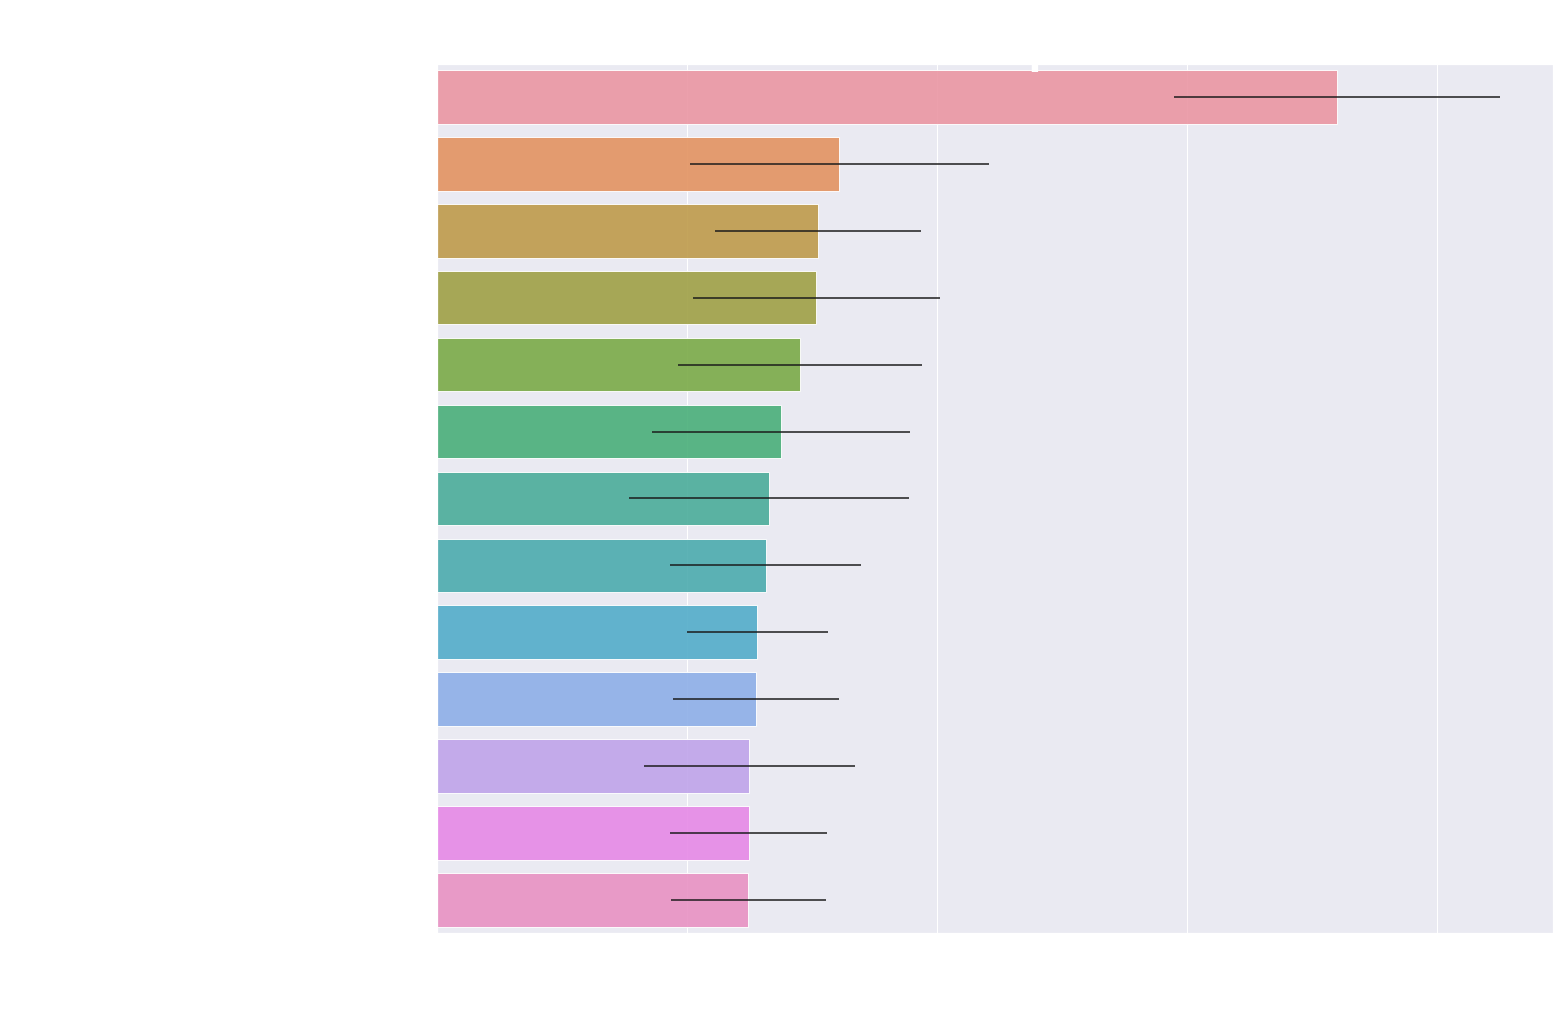

In [150]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)


# importances = logmodel.coef_[0,:]
# std = importances * 0.0

#std = 0.0*logmodel.coef_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


df_a = df_tmp.drop(['fav_win'],axis=1)
vec = df_a.keys()[:]


vec = ['$\Delta$ Prize Rating', '$\Delta$ Rating', '$\Delta$ HS %', '$\Delta$ Kills',
       '$\Delta$ Deaths', '$\Delta$ ADR', '$\Delta$ KAST', '$\Delta$ Assists',
       '$\Delta$ Flash', '$\Delta$ First Kills', '$\Delta$ Rank',
       '$\Delta$ Score', '$\Delta$ Win %']

for f in range(X_train.shape[1]):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], vec[ indices[f] ],  importances[indices[f]]))

# Plot the feature importances of the forest
%matplotlib inline


sns.set_style("whitegrid")
sns.set(font_scale=6)

plt.figure(figsize=(20,16))

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})


plt.title("Feature importance")

ax = sns.barplot(y=vec,x=importances[indices],xerr=std[indices],alpha=0.9, capsize=.2, errcolor='red' )


plt.savefig('feature.png', transparent=True, bbox_inches="tight")

# plt.xticks(range(X_train.shape[1]), indices)
# plt.xlim([-1, X_train.shape[1]])

# plt.bar(importances[indices],range(X_train.shape[1]), 
#        color="r", yerr=std[indices], align="center")
# plt.yticks(range(X_train.shape[1]), indices)
# plt.ylim([-1, X_train.shape[1]])

plt.show()

In [103]:
std

array([0.03258829, 0.02569328, 0.0165668 , 0.02791916, 0.01563082,
       0.02466436, 0.02992091, 0.019171  , 0.01555494, 0.01408958,
       0.02060209, 0.02103593, 0.02434842])

In [ ]:
# filename = 'model_jan30.sav'
# pickle.dump( logmodel, open(filename,'wb') )

In [ ]:
df_tmp.keys()

# Neural Network

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [ ]:
dataset = df_tmp.values
X = dataset[:,0:15].astype(float)
Y = dataset[:,15]

Y

In [ ]:
# Re-order columns
time_1 = datetime.now()

df_tmp.keys()
df_tmp = df_tmp[['shift_win_rate_0', 'shift_win_rate_1', 't_0_p_0_rating',
       't_0_p_1_rating', 't_0_p_2_rating', 't_0_p_3_rating', 't_0_p_4_rating',
       't_0_avg_rating', 't_1_p_0_rating', 't_1_p_1_rating', 't_1_p_2_rating',
       't_1_p_3_rating', 't_1_p_4_rating', 'rating_dif', 'prize_rating_dif','fav_win']]

# split into input (X) and output (Y) variables
n_input = 15

n_test = 10466

n_splits = 10  # Default 10
n_epochs = 100 # Default 100
n_batch  = 5   # Default 5

dataset = df_tmp.values
X = dataset[0:n_test,0:15].astype(float)
Y = dataset[0:n_test,15]

encoded_Y = Y

# encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
# with tf.device('/device:GPU:0'):

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(n_input, input_dim=n_input, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset

estimator = KerasClassifier(build_fn=create_baseline, epochs=n_epochs, batch_size=n_batch, verbose=0)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

time_2 = datetime.now()

print( time_2-time_1 )